In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import librosa 
import IPython.display as ipd
import librosa.display

os : Interacts with the operating system.

matplotlib.pyplot : Creates visualizations like graphs.

numpy : Handles numerical computations and arrays.

Librosa : This library is used for both audio and video analysis.

IPython.display: Displays audio in Jupyter/IPython environments.

In [2]:
def load_wav_16k_mono(filename):
    # Load audio file using librosa
    audio_data, sample_rate = librosa.load(filename, sr=16000, mono=True)
    return audio_data

The function returns the loaded audio data as a NumPy array (audio_data), representing the mono audio signal sampled at 16,000 Hz.

In [3]:
directory = r"D:\Noisy_Speech_Database"
clean1 = os.path.join(directory, 'clean_trainset_28spk_wav', 'p226_002.wav')
noisy1 = os.path.join(directory, 'noisy_trainset_28spk_wav', 'p226_013.wav')

In [4]:
ipd.Audio(clean1)

In [5]:
ipd.Audio(noisy1)

In [6]:
clean_ex = load_wav_16k_mono(clean1)
noisy_ex = load_wav_16k_mono(noisy1)

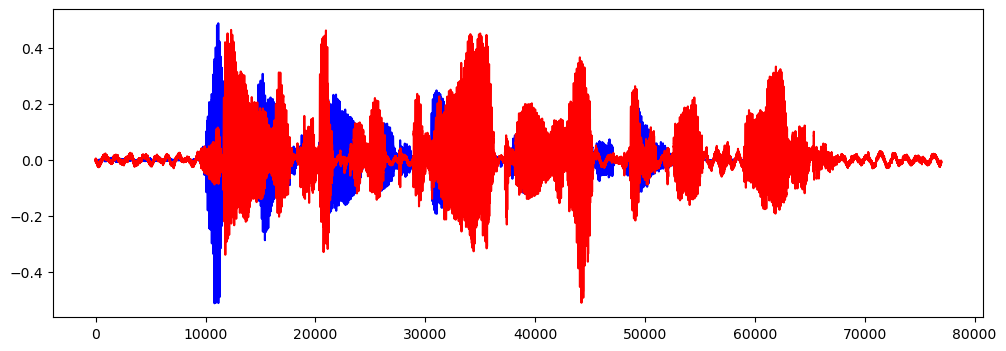

In [7]:
plt.figure(figsize=(12, 4))
plt.plot(clean_ex, 'b')
plt.plot(noisy_ex, 'r')
plt.show()

In [9]:
def preprocess(file_path, label, sample_rate=16000, max_length=48000, target_shape=(128, 128)):
    # Load the audio file using librosa
    audio_data, sr = librosa.load(file_path, sr=sample_rate, mono=True)
    
    # Truncate or pad the audio to a specific length
    if len(audio_data) < max_length:
        audio_data = np.pad(audio_data, (0, max_length - len(audio_data)), 'constant')
    else:
        audio_data = audio_data[:max_length]
    
    # Compute the spectrogram using librosa and resize it
    spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_fft=512,
                                                hop_length=256, win_length=320)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    
    # Resize the spectrogram
    spectrogram = np.resize(spectrogram, target_shape)  # Resizing to target_shape
    
    # Expand dimensions to match the TensorFlow output format
    spectrogram = np.expand_dims(spectrogram, axis=2)
    
    return spectrogram, label

Adjusting Audio Length : Truncates or pads the audio data to a maximum length ('max_length') specified. Padding adds zeros to make shorter audio reach the specified length, while truncating cuts longer audio to fit the specified length.

Computing Spectrogram : Computes the mel spectrogram of the processed audio using Librosa. Adjusts the spectrogram to decibel scale using 'librosa.power_to_db'.

Resizing Spectrogram : Resizes the spectrogram to a specified 'target_shape' for further preprocessing.

Formatting for TensorFlow : Adapts the spectrogram's shape to match the expected format for TensorFlow models by adding an extra dimension.

In [10]:
# Paths to clean and noisy directories
clean_dir = os.path.join(directory, 'clean_trainset_28spk_wav')
noisy_dir = os.path.join(directory, 'noisy_trainset_28spk_wav')

In [11]:
# List all files in the directories with corresponding labels
clean_files = [(os.path.join(clean_dir, filename), 1) for filename in os.listdir(clean_dir) if filename.endswith('.wav')]
noisy_files = [(os.path.join(noisy_dir, filename), 0) for filename in os.listdir(noisy_dir) if filename.endswith('.wav')]

Along with the file paths, labels are also added. 1 for Clean files and 0 for Noisy files

In [12]:
# Merge clean and noisy files into a single list
all_files = clean_files + noisy_files

Combined both Clean and Noisy Files

In [13]:
# Preprocess data and assign labels
preprocessed_data = []
for file_path, label in all_files:
    spectrogram, label = preprocess(file_path, label)
    preprocessed_data.append((spectrogram, label))

Converting all the .wav files into the spectogram values of array with the respective label and appended it in the seperate list

In [14]:
# Separate the spectrograms and labels
spectrograms, labels = zip(*preprocessed_data)

unzipping and seperating both the spectograms and labels.

In [15]:
# Convert preprocessed data to NumPy arrays
spectrograms = np.array(spectrograms)
labels = np.array(labels)

In [16]:
X=spectrograms
y=labels

For model building created X & y variables

In [17]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import tensorflow as tf : Imports the TensorFlow library for machine learning and deep neural networks.

from tensorflow.keras.models import Sequential : Imports the Keras Sequential model, allowing the creation of neural network models layer by layer.

from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization : Imports specific layer types (e.g., Conv2D, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization) used to build neural network architectures.

Sequential() : Initializes a sequential neural network model in Keras, allowing the creation of models layer by layer.

Conv2D() : Creates a 2D convolutional layer used for spatial convolution over images.

Dense() : Adds a fully connected (dense) layer to the neural network model.

Flatten() : Flattens the input, converting multi-dimensional data into a one-dimensional array.

MaxPooling2D() : Performs max pooling operation for reducing the spatial dimensions of the input volume.

Dropout() : Applies dropout regularization to the input, randomly setting a fraction of input units to zero during training to 
prevent overfitting. Means deactivation of neurons.

BatchNormalization() : Normalizes and scales inputs, aiding faster convergence and better performance in deep neural networks.

In [18]:
# Define the CNN model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=X.shape[1:]))  # Assuming X.shape[1:] provides the input shape
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer to transition from convolutional to dense layers
model.add(Flatten())

# Dense layers
model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Adding dropout for regularization
model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 128)             

model.compile() : Configures the model for training.

optimizer='adam' : Uses the Adam optimization algorithm.

loss='binary_crossentropy' : Appropriate for binary classification tasks.

metrics=['accuracy']: Evaluates model performance based on accuracy during training.

In [19]:
# Train the model
history = model.fit(X, y, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5


271/271 [==============================] - 49s 177ms/step - loss: 0.2572 - accuracy: 0.9703 - val_loss: 0.1115 - val_accuracy: 1.0000
Epoch 2/5
271/271 [==============================] - 48s 176ms/step - loss: 0.1523 - accuracy: 0.9818 - val_loss: 10.4160 - val_accuracy: 0.1939
Epoch 3/5
271/271 [==============================] - 48s 177ms/step - loss: 0.1241 - accuracy: 0.9844 - val_loss: 0.0661 - val_accuracy: 1.0000
Epoch 4/5
271/271 [==============================] - 48s 177ms/step - loss: 0.0978 - accuracy: 0.9848 - val_loss: 0.0400 - val_accuracy: 1.0000
Epoch 5/5
271/271 [==============================] - 48s 178ms/step - loss: 0.0883 - accuracy: 0.9881 - val_loss: 0.1029 - val_accuracy: 0.9734


batch_size=64 : Determines the number of samples processed before updating the model's weights.

validation_split=0.2 : Splits a portion (20%) of the data as a validation set to monitor model performance during training.

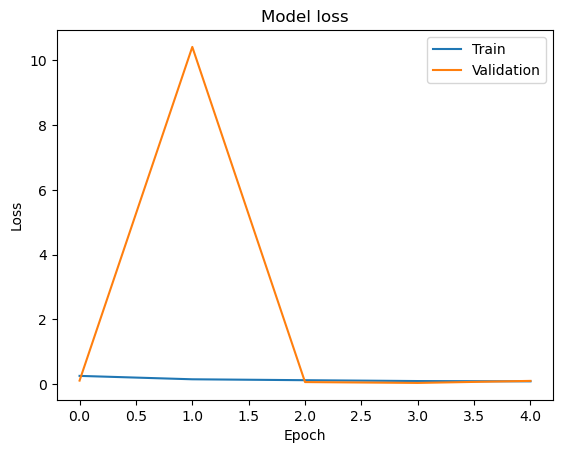

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

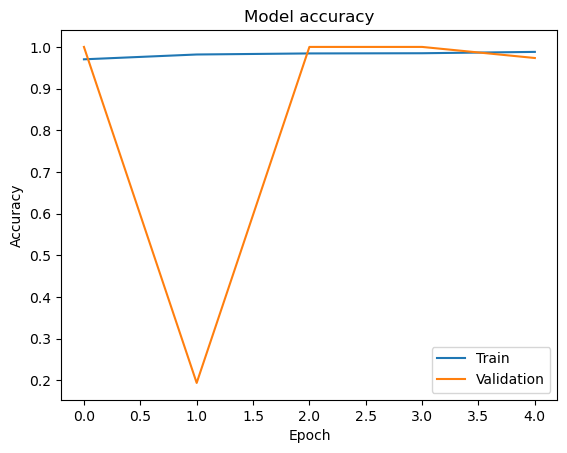

In [21]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])A
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [37]:
def preprocess_test(file_path, sample_rate=16000, max_length=48000, target_shape=(128, 128)):
    audio_data, sr = librosa.load(file_path, sr=sample_rate, mono=True)
    if len(audio_data) < max_length:
        audio_data = np.pad(audio_data, (0, max_length - len(audio_data)), 'constant')
    else:
        audio_data = audio_data[:max_length]
    spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_fft=512,
                                                hop_length=256, win_length=320)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    spectrogram = np.resize(spectrogram, target_shape)
    spectrogram = np.expand_dims(spectrogram, axis=2)
    return spectrogram

# File path of the test audio
test_audio_path = r"D:\Noisy_Speech_Database\clean_testset_wav\p232_005.wav"

preprocessed_test_audio = preprocess_test(test_audio_path)

Testing the Audio Files using the Model

In [38]:
# Predict on the preprocessed test audio
predictions = model.predict(np.array([preprocessed_test_audio]))

if predictions >= 0.5:
    prediction = 1
else:
    prediction = 0

# Display the prediction result
print("Prediction:", prediction)

1/1 [==============================] - 0s 24ms/step
Prediction: 1
